# Smart Scheduling Tool Project 
## using CO2 sensor data to infer attendance/engagement

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Load data (skip metadata rows)
df = pd.read_csv('sensor_data.csv', skiprows=3)
df['_time'] = pd.to_datetime(df['_time'])  # Convert to datetime
display(df)

,Unnamed: 0,result,table,_start,_stop,_time,_value,_field,_measurement,location
0,NaN,NaN,0,2019-08-28T22:00:00Z,2025-02-28T09:51:20.021037182Z,2023-07-25 13:50:42+00:00,472.0,co2,Sensors,am3019-testqc2090
1,NaN,NaN,0,2019-08-28T22:00:00Z,2025-02-28T09:51:20.021037182Z,2023-07-25 14:00:42+00:00,466.0,co2,Sensors,am3019-testqc2090
2,NaN,NaN,0,2019-08-28T22:00:00Z,2025-02-28T09:51:20.021037182Z,2023-07-25 14:10:42+00:00,466.0,co2,Sensors,am3019-testqc2090
3,NaN,NaN,0,2019-08-28T22:00:00Z,2025-02-28T09:51:20.021037182Z,2023-07-25 14:20:42+00:00,455.0,co2,Sensors,am3019-testqc2090
4,NaN,NaN,0,2019-08-28T22:00:00Z,2025-02-28T09:51:20.021037182Z,2023-07-25 14:30:42+00:00,463.0,co2,Sensors,am3019-testqc2090
...,...,...,...,...,...,...,...,...,...,...
4332087,NaN,NaN,98,2019-08-28T22:00:00Z,2025-02-28T09:51:20.021037182Z,2025-02-28 09:03:18.576343596+00:00,230.0,tvoc,Sensors,q4-1003-7456
4332088,NaN,NaN,98,2019-08-28T22:00:00Z,2025-02-28T09:51:20.021037182Z,2025-02-28 09:13:18.285268126+00:00,243.0,tvoc,Sensors,q4-1003-7456
4332089,NaN,NaN,98,2019-08-28T22:00:00Z,2025-02-28T09:51:20.021037182Z,2025-02-28 09:23:18.001500928+00:00,252.0,tvoc,Sensors,q4-1003-7456
4332090,NaN,NaN,98,2019-08-28T22:00:00Z,2025-02-28T09:51:20.021037182Z,2025-02-28 09:33:18.905404554+00:00,260.0,tvoc,Sensors,q4-1003-7456


## CO2 data preprocessing

In [ ]:
# Filter for CO2 data only
co2_df = df[df['_field'] == 'co2'].copy().sort_values('_time')

# Remove outliers (e.g., sensor errors)
Q1 = co2_df['_value'].quantile(0.25)
Q3 = co2_df['_value'].quantile(0.75)
IQR = Q3 - Q1
co2_df = co2_df[~((co2_df['_value'] < (Q1 - 1.5 * IQR)) | (co2_df['_value'] > (Q3 + 1.5 * IQR)))]

# Add time-based features
co2_df['hour'] = co2_df['_time'].dt.hour
co2_df['day_of_week'] = co2_df['_time'].dt.day_name()

## CO2 ↔ Attendance Correlation

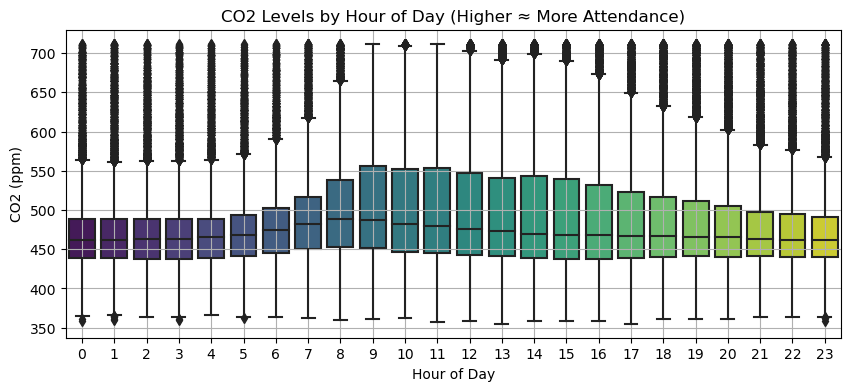

In [10]:
# Plot CO2 trends by hour (proxy for occupancy)
plt.figure(figsize=(10, 4))
sns.boxplot(data=co2_df, x='hour', y='_value', palette='viridis')
plt.title("CO2 Levels by Hour of Day (Higher ≈ More Attendance)")
plt.ylabel("CO2 (ppm)")
plt.xlabel("Hour of Day")
plt.grid(True)
plt.show()

## Peak Hours

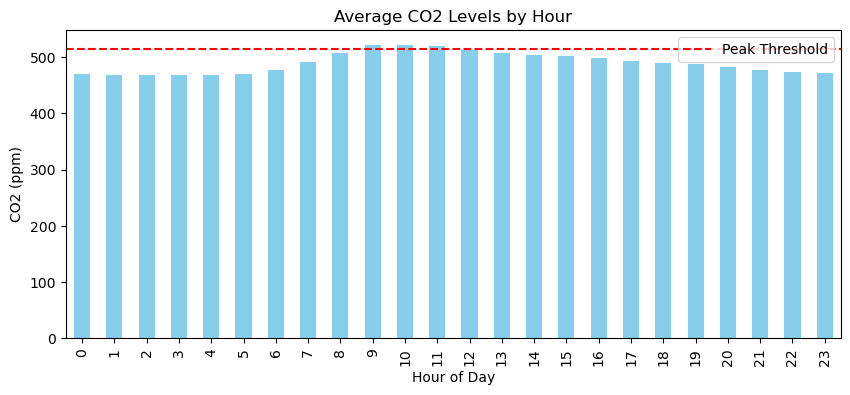

--- Peak Engagement Hours (CO2 > 515 ppm) ---
_time
10    522.703788
9     522.291817
11    520.594204
12    513.483096
8     508.185555
Name: _value, dtype: float64


In [ ]:
# Resample to hourly averages
hourly_avg = co2_df.set_index('_time').resample('H')['_value'].mean()

# Define "peak" hours (top 25% CO2 levels)
peak_threshold = hourly_avg.quantile(0.75)
peak_hours = hourly_avg[hourly_avg > peak_threshold]

# Plot CO2 levels by hour (with peak threshold)
plt.figure(figsize=(10, 4))
hourly_avg.groupby(hourly_avg.index.hour).mean().plot(kind='bar', color='skyblue')
plt.axhline(y=peak_threshold, color='red', linestyle='--', label='Peak Threshold')
plt.title("Average CO2 Levels by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("CO2 (ppm)")
plt.legend()
plt.show()

# Print peak hours
print("--- Peak Engagement Hours (CO2 > {:.0f} ppm) ---".format(peak_threshold))
print(hourly_avg.groupby(hourly_avg.index.hour).mean().sort_values(ascending=False).head(5))

## Weekly Patterns

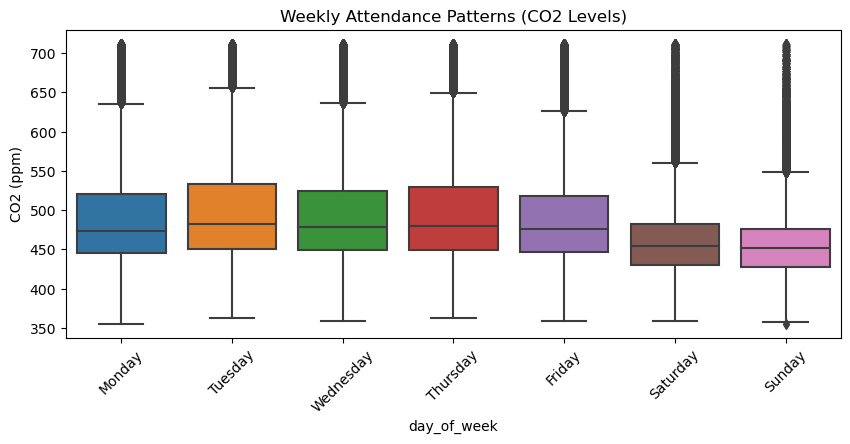

In [7]:
# Group by day of week
plt.figure(figsize=(10, 4))
sns.boxplot(data=co2_df, x='day_of_week', y='_value', 
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Weekly Attendance Patterns (CO2 Levels)")
plt.ylabel("CO2 (ppm)")
plt.xticks(rotation=45)
plt.show()